In [70]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 30)

## Chargement des données

On commence par charger le fichier qui indique les réponses des participants au questionnaire. Les réponses aux questions sont codées par des nombres, la signification des codes est fournie dans un fichier annexe de documentation. On va donc devoir jongler entre les deux.

In [124]:
df_brut = pd.read_excel("Data/Etude sur les Français et l_information/les-francais-et-l-information-arcom-2024-base-anonymisee.xlsx")
df_doc = pd.read_excel("Data/Etude sur les Français et l_information/Documentation/les-francais-et-l-information-arcom-2024-datamap.xlsx", sheet_name='TEXTS')

print("format des données brutes: ", df_brut.shape)

format des données brutes:  (3346, 1076)


Le fichier des données brutes contient des colonnes récapitulatives qui donnent une information redondante, on va supprimer celles-ci pour alléger le dataset.

In [125]:
# Suppression des colonnes "récap" dans la documentation
colonnes_récap = df_doc[df_doc["FR:L"].str.contains("Récap", case=False, na=False)]["NAME"]
#df_doc = df_doc.drop(index=colonnes_récap.index)

# Suppression des colonnes "récap" dans les données
colonnes_récap = [col for col in df_brut.columns if any(mot in col for mot in colonnes_récap)]
df_new = df_brut.drop(columns=colonnes_récap)

print(f"{len(colonnes_récap)} colonnes ont été supprimées. Il en reste {df_new.shape[1]}")

481 colonnes ont été supprimées. Il en reste 595


In [126]:
# Dictionnaire pour stocker les résultats
resultats = {}

# Parcours du DataFrame
current_title = None  # Clé pour le dictionnaire
start_index = None  # Indique l'index de début des lignes LABEL

for i, row in df_doc.iterrows():
    if row["TYPE"] == "TITLE":
        # Sauvegarde le sous-DataFrame précédent si un TITLE est déjà en cours
        if current_title is not None and start_index is not None:
            resultats[current_title] = df_doc.iloc[start_index:i]

        # Met à jour le titre courant et le début des lignes LABEL
        current_title = row["FR:L"]
        start_index = i + 1

# Ajoute le dernier sous-DataFrame après le dernier TITLE
if current_title is not None and start_index is not None:
    resultats[current_title] = df_doc.iloc[start_index:]

# Affichage des résultats
for key, sub_df in resultats.items():
    print(f"Bloc '{key}':")
    print(sub_df)
    print()


Bloc 'Records':
Empty DataFrame
Columns: [HEADER TEXT, NAME, TYPE, CODE, VALUE, FORMULA, BASE, GROUPID, FR:L]
Index: []

Bloc 'record: Record number':
Empty DataFrame
Columns: [HEADER TEXT, NAME, TYPE, CODE, VALUE, FORMULA, BASE, GROUPID, FR:L]
Index: []

Bloc 'uuid: Participant identifier':
Empty DataFrame
Columns: [HEADER TEXT, NAME, TYPE, CODE, VALUE, FORMULA, BASE, GROUPID, FR:L]
Index: []

Bloc 'cible: Cible':
  HEADER TEXT   NAME   TYPE  ...  BASE  GROUPID                   FR:L
4        TEXT  CIBLE  LABEL  ...   NaN      NaN  France métropolitaine
5        TEXT  CIBLE  LABEL  ...   NaN      NaN                DOM TOM
6        TEXT  CIBLE  LABEL  ...   NaN      NaN                DOM - 2

[3 rows x 9 columns]

Bloc 'Source':
   HEADER TEXT            NAME   TYPE  ...  BASE  GROUPID            FR:L
8         TEXT  SOURCE_BASE_R1  LABEL  ...  -1.0      1.0            CATI
9         TEXT  SOURCE_BASE_R1  LABEL  ...   NaN      1.0  CAWI Métropole
10        TEXT  SOURCE_BASE_R1  LABEL

In [103]:
df_frequences_média = df_new[['RS2C_RECODE_AG_R', "NEWS1_R_1","NEWS1_R_2","NEWS1_R_3","NEWS1_R_4","NEWS1_R_5","NEWS1_R_6","NEWS1_R_7", "NEWS1_R_8", "NEWS1BIS_R"]]
df_frequences_média = df_frequences_média.rename(columns = {
    "RS2C_RECODE_AG_R": "Tranche d'âge",
    "NEWS1_R_1": "En écoutant la radio ou des podcast",
    "NEWS1_R_2": "En regardant la TV (replay ou direct)",
    "NEWS1_R_3": "En lisant un journal ou magazine",
    "NEWS1_R_4": "En vous connectant directement sur un site internet",
    "NEWS1_R_5": "En utilisant un moteur de recherche",
    "NEWS1_R_6": "En utilisant un portail d'actualité",
    "NEWS1_R_7": "En consultant les réseaux sociaux",
    "NEWS1_R_8": "En consultant les plateformes vidéo en ligne",
    "NEWS1BIS_R": "Mode principal d'information"
    })

doc_age = df_doc.loc[21:27]
df_frequences_média["Tranche d'âge"] = df_frequences_média["Tranche d'âge"].apply(lambda x: doc_age[doc_age["CODE"]==x]["FR:L"].iloc[0])

doc_news = df_doc.loc[252:257]
for col in df_frequences_média.columns[1:-1]:
    df_frequences_média[col] = df_frequences_média[col].apply(lambda x: doc_news[doc_news["CODE"]==x]["FR:L"].iloc[0] if x in doc_news["CODE"].unique()  else x)

doc_newsbis = df_doc.loc[319:327]
col = "Mode principal d'information"
df_frequences_média[col] = df_frequences_média[col].apply(lambda x: doc_newsbis[doc_newsbis["CODE"]==x]["FR:L"].iloc[0] if x in doc_newsbis["CODE"].unique()  else x)

df_frequences_média.to_csv("mode_d_information.csv")


In [99]:
col = "En consultant les plateformes vidéo en ligne"
df_frequences_média[col] = df_frequences_média[col].apply(lambda x: doc_news[doc_news["CODE"]==x]["FR:L"].iloc[0] if x in doc_news["CODE"].unique() else x)

In [91]:
set(doc_news["CODE"])== set(df_frequences_média[col].unique()) -set([np.nan])

False

In [98]:
df_frequences_média[col].iloc[0]

nan

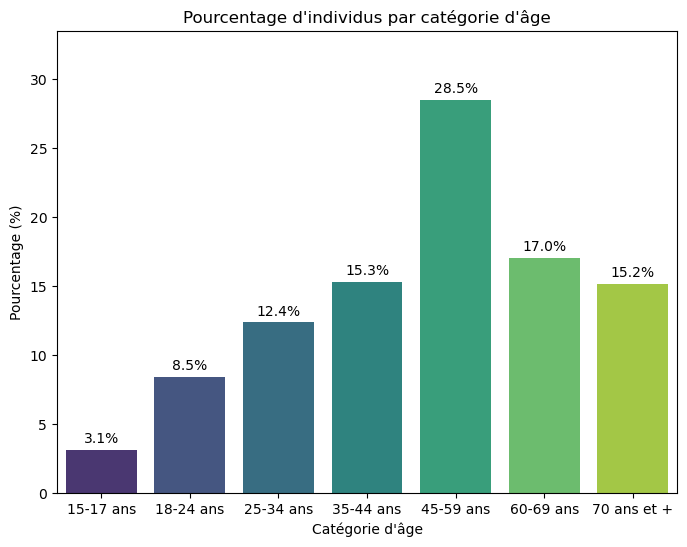

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcul des pourcentages
age_counts = df_brut['RS2C_RECODE_AG_R'].value_counts(normalize=True).sort_index() * 100

# Création du barplot
plt.figure(figsize=(8, 6))
sns.barplot(x=age_counts.index, y=age_counts.values, palette="viridis")

# Ajout des labels et titre
plt.xlabel('Catégorie d\'âge')
plt.ylabel('Pourcentage (%)')
plt.title('Pourcentage d\'individus par catégorie d\'âge')
plt.xticks(ticks=range(len(age_counts)), labels=['15-17 ans', '18-24 ans', '25-34 ans', '35-44 ans', '45-59 ans', '60-69 ans','70 ans et +'])
plt.ylim(0, max(age_counts.values) + 5)

# Affichage des pourcentages au-dessus des barres
for index, value in enumerate(age_counts.values):
    plt.text(index, value + 0.5, f'{value:.1f}%', ha='center', fontsize=10)

plt.show()


In [22]:
df_doc.head(70)

,HEADER TEXT,NAME,TYPE,CODE,VALUE,FORMULA,BASE,GROUPID,FR:L
0,TEXT,LEVEL_A,TITLE,NaN,NaN,NaN,NaN,NaN,Records
1,TEXT,RECORD,TITLE,NaN,NaN,NaN,NaN,NaN,record: Record number
2,TEXT,UUID,TITLE,NaN,NaN,NaN,NaN,NaN,uuid: Participant identifier
3,TEXT,CIBLE,TITLE,NaN,NaN,NaN,NaN,NaN,cible: Cible
4,TEXT,CIBLE,LABEL,1.0,NaN,NaN,NaN,NaN,France métropolitaine
...,...,...,...,...,...,...,...,...,...
65,TEXT,UDA9_R,LABEL,5.0,NaN,NaN,0.0,1.0,Est
66,TEXT,UDA9_R,LABEL,6.0,NaN,NaN,0.0,1.0,Bassin Parisien Est
67,TEXT,UDA9_R,LABEL,7.0,NaN,NaN,0.0,1.0,Sud Ouest
68,TEXT,UDA9_R,LABEL,8.0,NaN,NaN,0.0,1.0,Sud Est


In [ ]:
dico_questions = {
    "CIBLE": "Cible",
    "SOURCE_BASE_R1": "Source",
    "POIDS03": "Poids",
    "RS1_R": "Genre",
    "RS2C_RECODE_AG_R": "Age",
    "RS3_R":"Situation professionnelle",
    "RS4_R": "Profession",
    "CSPIND_R": "CSP",
    "RS5_R": "Niveau d'étude",
    "UDA9_R": "Région en 9",
    "UDA5_R": "Région en 5",
    "DPT_DOM": "DOM",
    "CC_R": "Taille agglo",
    "RS7_R":"Nombre de personnes dans le foyer",
    "RS14_R": "Revenu mensuel net du foyer",
    "ILLECTRO_R": "Dernière utilisation d'internet",
    "RS15_R": "Fréquence d'utilisation d'internet",
    "FREQ_INTERNET_R": "Fréquence d'utilisation d'internet (recode)",
    
    "RS16_R": "Équipement média",
    "RS16_R_1": "un poste de TV",
    "RS16_R_2": "un poste de radio, une chaine hifi",
    "RS16_R_3": "un autoradio",
    "RS16_R_4": "un smartphone",
    "RS16_R_5": "un ordinateur fixe",
    "RS16_R_6": "un ordianteur portable",
    "RS16_R_7": "une tablette tactile",
    "RS16_R_8": "la google chromecast, le firestick amazon ou une box appleTV",
    "RS16_R_9": "une enceinte connectée avec assistant vocal",
    "RS16_R_10": "un casque VR",
    "RS16_R_11": "une montre connectée",
    "RS16_R_12": "une console de jeux",
    
    "INT1_R": "Intérêt global pour l'information",
    
    "INT2_R": "Intérêt détaillé pour l'information sur un thème",
    "INT2_R_1": "Actualité internationale",
    "INT2_R_2": "Actualité nationale",
    "INT2_R_3": "Actualité locale / régionale ",
    "INT2_R_4": "Politique",
    "INT2_R_5": "Économie",
    "INT2_R_6": "Société (justice, emplois, fait-divers)",
    "INT2_R_7": "Environnement",
    "INT2_R_8": "Santé, mode de vie et bien-être",
    "INT2_R_9": "Culture et divertissement",
    "INT2_R_10": "Sport",
    "INT2_R_11": "People",
    "INT2_R_12": "Science et technologie",
    
    "VERSION_QUESTIO_R": "Version du questionnaire",
    
    "INT3_R": "Sentiment d'être bien informé sur les thèmes d'intérêt",
    "INT3_R": "Intérêt détaillé pour l'information sur un thème",
    "INT3_R_1": "Actualité internationale",
    "INT3_R_2": "Actualité nationale",
    "INT3_R_3": "Actualité locale / régionale ",
    "INT3_R_4": "Politique",
    "INT3_R_5": "Économie",
    "INT3_R_6": "Société (justice, emplois, fait-divers)",
    "INT3_R_7": "Environnement",
    "INT3_R_8": "Santé, mode de vie et bien-être",
    "INT3_R_9": "Culture et divertissement",
    "INT3_R_10": "Sport",
    "INT3_R_11": "People",
    "INT3_R_12": "Science et technologie",
    
    "MOTIV_R_1": "Comprendre ce qui m'entoure",
    "MOTIV_R_2": "Rester informé des grands événements",
    "MOTIV_R_3": "Me faire ma propre opinion",
    "MOTIV_R_4": "Prendre des décisions éclairées en tant que citoyen",
    "MOTIV_R_5": "Pouvoir en discuter et débattre avec mon entourage",
    "MOTIV_R_6": "Me divertir",
    "MOTIV_R_7": "Découvrir des tendances ou cultures",
    "MOTIV_R_8": "Satisfaire ma curiosité",
    "MOTIV_R_9": "Passer le temps",
    "MOTIV_R_10": "M'instruire, me cultiver",
    "MOTIV_R_11": "Progresser dans mon travail, mes études",
    "MOTIV_R_12": "Connaître d'autres avis que le mien",
    "MOTIV_R_14": "Par habitude",
    "MOTIV_R_15": "Aucune",
    
    "NEWS1_R_1": "En écoutant la radio ou des podcast",
    "NEWS1_R_1": "En regardant la TV (replay ou direct)",
    "NEWS1_R_1": "En lisant un journal ou magazine",
    "NEWS1_R_1": "En vous connectant directement sur un site internet",
    "NEWS1_R_1": "En utilisant un moteur de recherche",
    "NEWS1_R_1": "En utilisant un portail d'actualité",
    "NEWS1_R_1": "En consultant les réseaux sociaux",
    "NEWS1_R_1": "En consultant les plateformes vidéo en ligne",
    "NEWS1_1B_R": "Support d'écoute radio ou podcast",
    "NEWS1_2B_R": "Support pour regarder la TV",
    "NEWS1_3B_R": "Support de lecture de journeaux ou magazines",
    "NEWS1SOURCES_LR6_R": "Source des informations consultées via un moteur de recherche",
    "NEWS1SOURCES_LR7_R": "Source des informations consultées via un portail d'actualité",
    "NEWS1SOURCES_LR8_R": "Source des informations consultées via les réseaux sociaux",
    "NEWS1SOURCES_LR8_R": "Source des informations consultées via des vidéos en lignes",
    "NEWS1BIS_R": "Mode principal d'information",

    "PAY_R_1": "J'ai acheté des journaux ou magazines à l'unité en point de vente presse",
    "PAY_R_2": "J'ai acheté des articles de journaux ou magazines à l'unité en ligne",
    "PAY_R_3": "J'ai payé un abonnement à un ou plusieurs journaux ou magazines",
    "PAY_R_4": "J'ai payé un abonnement à un kiosque numérique",
    "PAY_R_5": "J'ai payé un abonnement à un site d'information en ligne",
    "PAY_R_6": "J'ai payé un abonnement à une newsletter",
    "PAY_R_7": "J'ai payé pour d'autres abonnements (Twitch, …)",

    "AGREG_R_1": "Flipboard",
    "AGREG_R_2": "Upday",
    "AGREG_R_3": "Google actualités",
    "AGREG_R_4": "Microsoft start",
    "AGREG_R_5": "Opéra news",
    "AGREG_R_6": "Orange actu",
    "AGREG_R_7": "Portail MSN",
    "AGREG_R_8": "Yahoo actualités",
    
    "NOTIF_R": "Activation des notification",
    
    "RSINFO_1_LR_R_1":"Utilise Facebook",
    "RSINFO_1_LR_R_2":"Utilise Instagram",
    "RSINFO_1_LR_R_3":"Utilise X",
    "RSINFO_1_LR_R_4":"Utilise TikTok",
    "RSINFO_1_LR_R_5":"Utilise Snapchat",
    "RSINFO_1_LR_R_6":"Utilise Linkedin",
    "RSINFO_1_LR_R_7":"Utilise WhatsApp",
    "RSINFO_1_LR_R_8":"Utilise Telegram",
    "RSINFO_1_LR_R_9":"Utilise Youtube",
    "RSINFO_1_LR_R_10":"Utilise Twitch",
    "RSINFO_1_LR_R_11":"Utilise Reddit",
    "RSINFO_1_LR_R_12":"Utilise Discord",
    "RSINFO_1_LR_R_13":"Utilise un autre réseau",
    "RSINFO_1_LR_R_14":"Aucun",
    
    "RSINFO_2_LR_R_1":"S'informe avec Facebook",
    "RSINFO_2_LR_R_2":"S'informe avec Instagram",
    "RSINFO_2_LR_R_3":"S'informe avec X",
    "RSINFO_2_LR_R_4":"S'informe avec TikTok",
    "RSINFO_2_LR_R_5":"S'informe avec Snapchat",
    "RSINFO_2_LR_R_6":"S'informe avec Linkedin",
    "RSINFO_2_LR_R_7":"S'informe avec WhatsApp",
    "RSINFO_2_LR_R_8":"S'informe avec Telegram",
    "RSINFO_2_LR_R_9":"S'informe avec Youtube",
    "RSINFO_2_LR_R_10":"S'informe avec Reddit",
    "RSINFO_2_LR_R_11":"S'informe avec Discord",
    "RSINFO_2_LR_R_12":"S'informe avec Twitch",
    "RSINFO_2_LR_R_13":"S'informe avec un autre réseau",
    }